# Rubin ToO Strategies
This notebook was put together to aid visualization of possible strategies to adopt for Target of Opportunity (ToO) observations with Vera C. Rubin Observatory. The notebook provides code for:
- visualization of the ToO observing strategies
- light curves plots
- exposure time calculator (ETC) to convert exposure times to limiting magnitudes and vice-versa
- time budget calculations

Notebook template author: Igor Andreoni <<igor.andreoni@gmail.com>> <br>
Code reviewed by Meet Vyas and Ritwik Sharma with equal merit.

### Requirements

Python3

- numpy
- matplotlib
- math
- scipy
- collections
- astropy

Custom scripts
- chart.py
- etc.py
- plot_lc.py

In [1]:
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Import the custom exposure time calculator
import etc

# Import the function to make the Gantt chart
from chart import makeChart

# Import function to complete the strategy dictionary with automatic calculations
from chart import complete_strategies

Build a dictionary with the strategies that you want to be seen on the same plot. 
The keys of the dictionary will be the nicknames of the strategies (for example, `strategy1`, `strategy2`).

Notes:
- The LSSTCam filter wheel holds 5 filters on a given night. The bluer and redder filters, u and y, will be swapped depending on the lunation. If all 6 filters are added to the plot, we shall assume that 5 available filters will be used in the ToOs.
- The length of the exposure time list (`exptimes_median` key) must be the same length as the cadence list (`cadence_hr` key) and the filters list (`filters` key);
- The cadence must be given in hours, the exposure times in seconds, the filters as a list or in the form `'ugrizy'`
- The `depths` are 5sigma limiting magnitudes in all bands, the corresponding exptime will be the median of the exposure times for the filters provided in each strategy
- <b>Important:</b> Order of "domination" of the inputs: individual `depths` (list of lists of depths per individual filters) dominate over `depths_median` (list of median depths per epoch), which dominates over individual `exptimes` (list of lists of exposure times per individual filters), which dominates over `exptimes_median` (list of median exposure times per epoch). All the other values will be calculated automatically using the ETC.

In [2]:
# Define the strategy
strategies = {
    'Fabulous Strategy': {"cadence_hr": [4, 24, 48],
                   "exptimes_median": [],
                   "exptimes": [],
                   "depths_median": [],
                   "depths": [[23, 24.5, 24.5, 24.5, 24., 22],
                              [23, 24.5, 24.5, 24.5, 24., 22],
                              [24, 25, 25, 25, 25., 23]
                              ],
                   "filters": ['ugrizy', 'ugrizy', 'ugrizy']},
    'Less Fabulous': {"cadence_hr": [6, 48],
                   "exptimes_median": [30, 30],
                   "exptimes": [],
                   "depths_median": [],
                   "depths": [],
                   "filters": ['grz', 'grz']},
    'Mixed bag': {"cadence_hr": [6, 24, 48],
                   "exptimes_median": [], # if this list is given
                   "exptimes": [[120, 30, 30, 30, 120, 200], [30, 30], [120, 120]],
                   "depths_median": [],
                   "depths": [],
                   "filters": ['ugrizy', 'gz', 'gz']}
}

# Airmass for the observations (>= 1.)
airmass = 1.2

# When is the timeline starting? e.g., Rubin Trigger, NS-NS merger, ...
event_name = "start of Rubin observing window"

# Output file name
filename_out = "plot_strategy.pdf"

# Define the colors for the Rubin filters
filters_color_dict = {'u':'b', 'g':'g', 'r':'r', 'i':'yellow', 'z':'k', 'y':'orange'}

# Define the sequence of markers for different exposure times
# (the sequence will be ordered by increasing exposure time)
exptimes_marker_list = ["o", "s", "p", "h", "8", '^']

# Complete the strategies using the ETC [do not modify the next line]
strategies = complete_strategies(strategies, airmass=airmass)

Fabulous Strategy: Using INDIVIDUAL DEPTHS to calculate the exposure times
Less Fabulous: Using MEDIAN EXPOSURE TIMES to calculate the depths
Mixed bag: Using INDIVIDUAL EXPOSURE TIMES to calculate median exposure times and depths


See how the `strategies` dictionary has been populated

In [3]:
strategies

{'Fabulous Strategy': {'cadence_hr': [4, 24, 48],
  'exptimes_median': [22, 22, 75],
  'exptimes': [[10, 14, 31, 62, 70, 12],
   [10, 14, 31, 62, 70, 12],
   [62, 34, 77, 156, 439, 73]],
  'depths_median': [24.25, 24.25, 25.0],
  'depths': [[23, 24.5, 24.5, 24.5, 24.0, 22],
   [23, 24.5, 24.5, 24.5, 24.0, 22],
   [24, 25, 25, 25, 25.0, 23]],
  'filters': ['ugrizy', 'ugrizy', 'ugrizy']},
 'Less Fabulous': {'cadence_hr': [6, 48],
  'exptimes_median': [30, 30],
  'exptimes': [[30, 30, 30], [30, 30, 30]],
  'depths_median': [24.49, 24.49],
  'depths': [[24.93, 24.49, 23.54], [24.93, 24.49, 23.54]],
  'filters': ['grz', 'grz']},
 'Mixed bag': {'cadence_hr': [6, 24, 48],
  'exptimes_median': [75, 30, 120],
  'exptimes': [[120, 30, 30, 30, 120, 200], [30, 30], [120, 120]],
  'depths_median': [23.855, 24.235, 24.235],
  'depths': [[23.6, 24.93, 24.49, 24.11, 23.54, 22.52],
   [24.93, 23.54],
   [24.93, 23.54]],
  'filters': ['ugrizy', 'gz', 'gz']}}

In [4]:
# Print the results in a more readable format
strategy_names = list(strategies.keys())
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    # Iterate over the epochs
    for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            print(f"    Epoch: {strategies[strategy_names[i]]['cadence_hr'][j]} hr")
            # Iterate over the filters
            for filt, exptime, depth in zip(strategies[strategy_names[i]]["filters"][j],
                                            strategies[strategy_names[i]]["exptimes"][j],
                                            strategies[strategy_names[i]]["depths"][j]):
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
            print(f"        Median exposure time: {strategies[strategy_names[i]]['exptimes_median'][j]}s")
    print("--")


 Strategy name: Fabulous Strategy
    Epoch: 4 hr
        Filter: u Depth: 23mag, exptime: 10s
        Filter: g Depth: 24.5mag, exptime: 14s
        Filter: r Depth: 24.5mag, exptime: 31s
        Filter: i Depth: 24.5mag, exptime: 62s
        Filter: z Depth: 24.0mag, exptime: 70s
        Filter: y Depth: 22mag, exptime: 12s
        Median exposure time: 22s
    Epoch: 24 hr
        Filter: u Depth: 23mag, exptime: 10s
        Filter: g Depth: 24.5mag, exptime: 14s
        Filter: r Depth: 24.5mag, exptime: 31s
        Filter: i Depth: 24.5mag, exptime: 62s
        Filter: z Depth: 24.0mag, exptime: 70s
        Filter: y Depth: 22mag, exptime: 12s
        Median exposure time: 22s
    Epoch: 48 hr
        Filter: u Depth: 24mag, exptime: 62s
        Filter: g Depth: 25mag, exptime: 34s
        Filter: r Depth: 25mag, exptime: 77s
        Filter: i Depth: 25mag, exptime: 156s
        Filter: z Depth: 25.0mag, exptime: 439s
        Filter: y Depth: 23mag, exptime: 73s
        Median ex

## Survey Strategy Visualization

The template code was used to produce some figures published in Andreoni et al. (2022), The Astrophysical Journal Supplement Series, Volume 260, Issue 1, id.18, 17 pp.

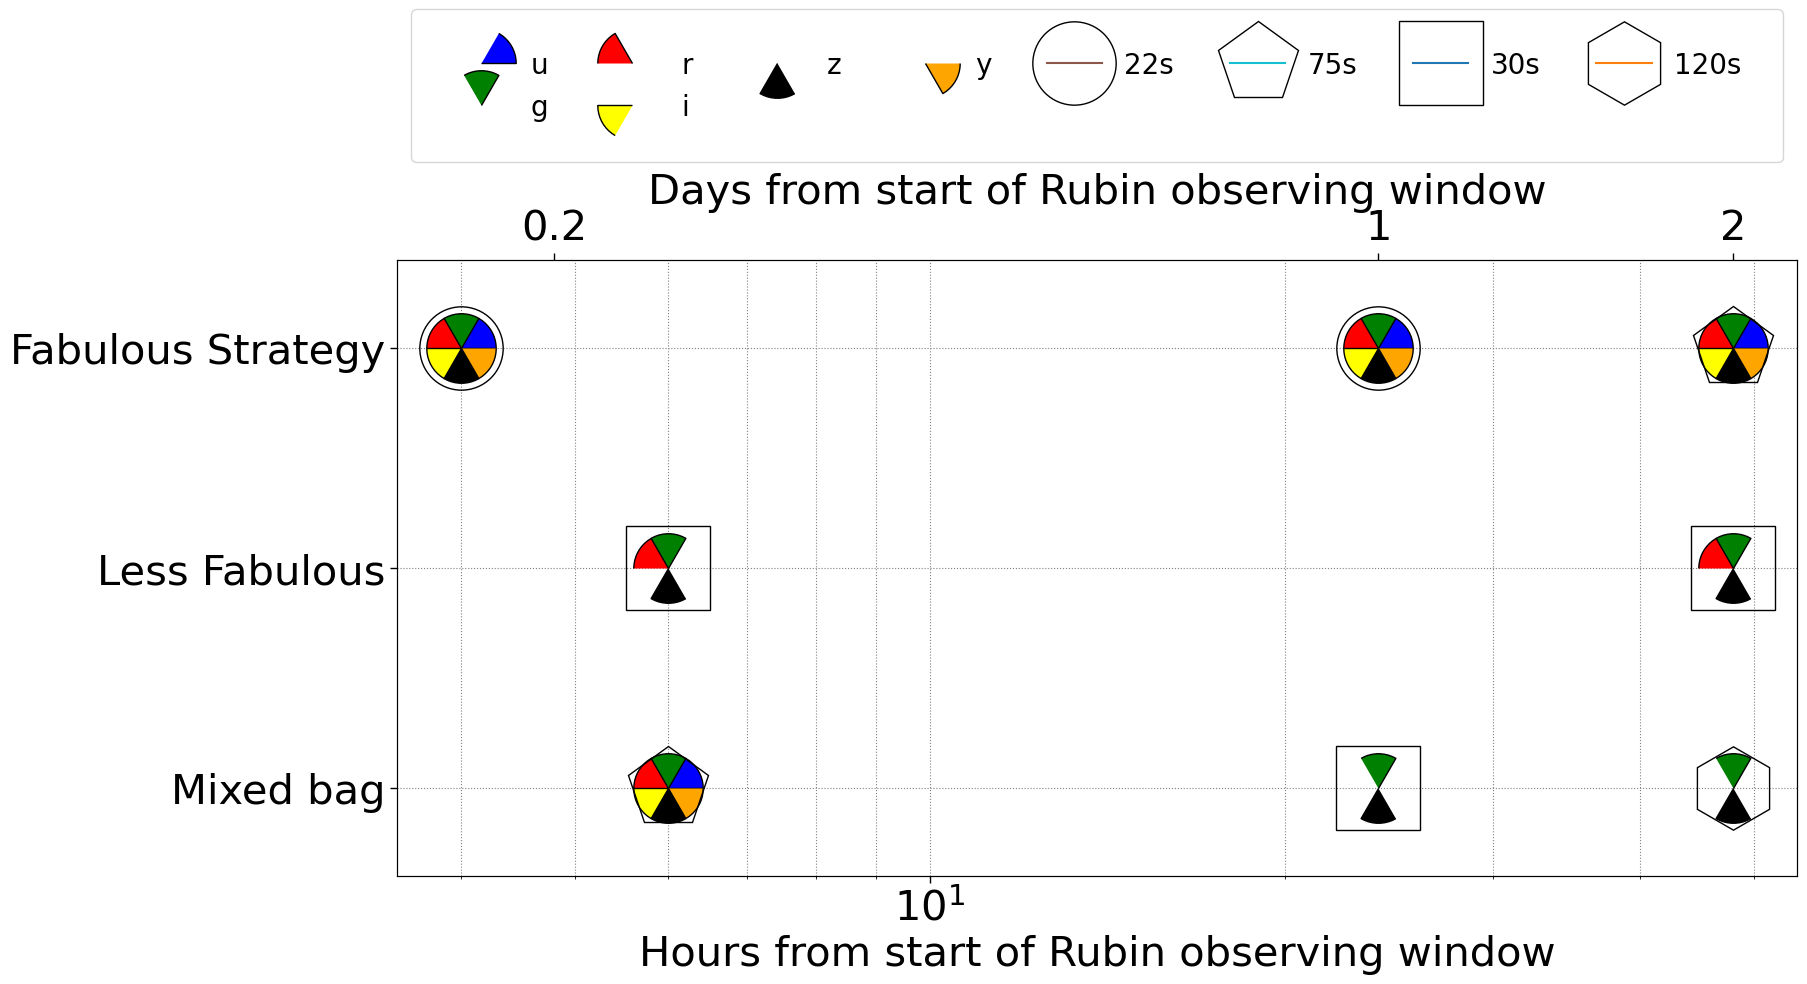

In [5]:
# Create the gantt chart
fig, ax = makeChart(strategies, event=event_name,
                    filters_color_dict=filters_color_dict,
                    exptimes_marker_list=exptimes_marker_list)

# Save the figure and show the plot
plt.savefig(filename_out, bbox_inches='tight')
plt.show()

See how the `strategies` dictionary has been populated

## Plot transient light curve

Plot the light curve of a transient given the strategy defined above.

In [6]:
import glob

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import Planck18 as cosmo
import astropy.cosmology as ac
import astropy.units as u

import plot_lc

One important variable to be set is `delay_hr`, which is the delay time between the onset of the transient (e.g., the merger of two compact objects) and the start of the observability window. Note that `cadence_hr` starts from the beginning of the observability window, since we cannot predict when the onset is, if the event happens during the Chilean daytime.

Light curve models come in ASCII or CSV files. Check out the `models/` folder and use the same format, if you want to add your favorite model. Simply assign the path to the model to the `model_filename` variable. 

A grid of kilonova light curves is available, which were obtained with 3D Monte Carlo radiative transfer code (Bulla 2019, 2023; Anand et al. 2023). Four parameters can be chosen: the dynamic ejecta mass `mej_dyn`, the disk wind ejecta mass `mej_wind`, the half opening angle of the lanthanide-rich dynamical-ejecta component `phi` and the viewing angle `theta` (see Dietrich et al. 2020, for more details about the adopted geometry). The grid is available for kilonovae at distances from 100Mpc to 700Mpc, which is twice the upper bound of the projected horizon for BNS mergers in O5, at intervals of 100Mpc. More of such light curves can be produced on demand (ask Igor). The best-fit parameters to GW170817, ignoring the distance, are:

```
inj_params_list = [{'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 25.8,
              'dist_Mpc': 300  #  Distance (Mpc), available from 100Mpc to 700Mpc at 100Mpc intervals
                   }]
```
Suggestions for parameters that can be used to probe a good range of models can be found in Table 2 in
[Andreoni et al. (2023)](https://ui.adsabs.harvard.edu/abs/2024APh...15502904A/abstract) and the models used in that paper are given here as a dictionary.

<b>Lensed kilonova</b> light curves are also available, from [Smith et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.520..702S/abstract). The brighter one is 170817-like in its SED and evolution and the fainter one is a more conservatively viewed and redder model. Both are placed at z=1.6. All details can be found in the paper.

In [7]:
# Delay between transient onset and start of the observing window
delay_hr = 6.

# Distance in Mpc, available from 100Mpc to 700Mpc at 100Mpc intervals
distance_Mpc = 400

# Here are some selected models from the Bulla+19, Anand+23 model grid. Do not modify unless necessary
# Please look at models/kilonova_Bulla/ folder for more options.
models = {"GW170817 best fit polar, theta=26deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_dMpc{distance_Mpc}.dat",
          "GW170817 best fit equatorial, theta=90deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta90.00_dMpc{distance_Mpc}.dat",
          "Kilonova low Y_e and M_ej, theta=45deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.15_wind0.010-0.03_theta45.57_dMpc{distance_Mpc}.dat",
          "Kilonova low Y_e, theta=26deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.15_wind0.050-0.03_theta25.84_dMpc{distance_Mpc}.dat",
          "Kilonova low M_e, theta=26deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.010-0.15-0.20_wind0.010-0.03_theta25.84_dMpc{distance_Mpc}.dat",
          "Kilonova high M_ej, theta=26deg": f"models/kilonova_Bulla/nph1.0e+06_dyn0.020-0.15-0.20_wind0.090-0.03_theta25.84_dMpc{distance_Mpc}.dat",
          "Lensed kilonova z=1.6 bright": f"models/kilonova_lensed_Nicholl/M1.188_q0.92_z1.6_C24_d0.12_v32_forIgor.txt",
          "Lensed kilonova z=1.6 faint": f"models/kilonova_lensed_Nicholl/M1.200_q0.90_z1.6_C0_d0.15_v60_forIgor.txt",
}

# Pick the model
model_filename = models["GW170817 best fit polar, theta=26deg"]

# Verbose
print(f"Selected model file name: \n {model_filename}")

Selected model file name: 
 models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_dMpc400.dat



 Strategy name: Fabulous Strategy


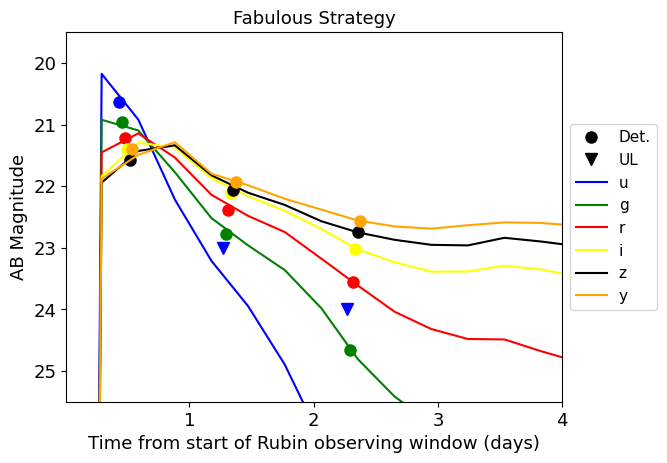


 Strategy name: Less Fabulous


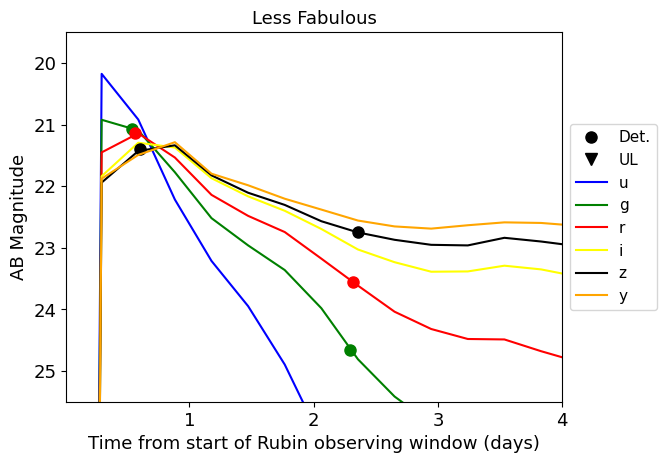


 Strategy name: Mixed bag


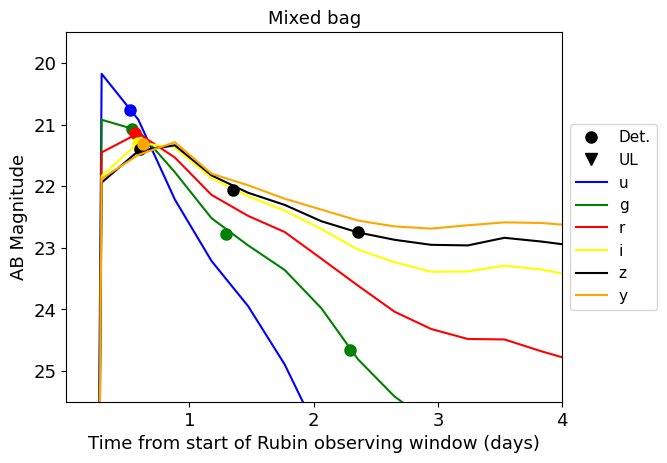

In [8]:
# Read the model
t_model = ascii.read(model_filename)
# Do plot 
plot_lc.doPlotLc(strategies, t_model,
                 delay_hr,  # delay time between merger and observing window
                 xlim=[0.01, 4], # x axis limit in apparent mag
                 ylim=[25.5, 19.5],  # y axis limit in apparent mag
                 n_interp=100,  # Number of points for the interpolation (e.g. 150)
                 offset_filt_hr=0.5,  # offset in hours between filters (to show overlapping points)
                 outfile_base="plot_lc",  # Base name for the file to be saved
                 outfile_format='pdf',  # Format of the output plot (pdf, png, etc)
                 doSave=True,  # If set to False, the plot will not be saved
                 event_name=event_name,  # Name of the event for the X label
                 linestyle="-",
                 filters_color_dict=filters_color_dict)

## Time budget

Based on the strategies adopted, compute the time budget. Some parameters need to be defined, such as:
- overheads between exposures (readout)
- overheads for the first slew
- overheads for the filter change
- number of fields (i.e., number of tiles)
- number of events (i.e., number of GW events or other)
- ratio of number of days in which u-band is mounted (10/30 for 10 days per month)

IMPORTANT: the filter change and first slew overhead will be divided by the number of fields, assuming that Rubin will complete a full pass of the tiling before changing filter. 

In [9]:
# Overheads
overhead_between_exposures = 7.  # in seconds

# Overhead first slew per epoch, assuming it may be further away than tiling
overhead_first_slew = 30

# Overhead for filter change
overhead_filter_change = 120.  # in seconds

# Number of fields
n_fields = 4

# Number of separate compact mergers (or other type of events) to follow-up
n_events = 5

# If 6 filters are given, one must be dropped. 
# Indicate here the number of days per month in which u band is used.
# Y band will be assumed for the other epochs. The total time budget will be a combination of the two.
u_days_ratio = 14./30

In [10]:
strategies

{'Fabulous Strategy': {'cadence_hr': [4, 24, 48],
  'exptimes_median': [22, 22, 75],
  'exptimes': [[10, 14, 31, 62, 70, 12],
   [10, 14, 31, 62, 70, 12],
   [62, 34, 77, 156, 439, 73]],
  'depths_median': [24.25, 24.25, 25.0],
  'depths': [[23, 24.5, 24.5, 24.5, 24.0, 22],
   [23, 24.5, 24.5, 24.5, 24.0, 22],
   [24, 25, 25, 25, 25.0, 23]],
  'filters': ['ugrizy', 'ugrizy', 'ugrizy']},
 'Less Fabulous': {'cadence_hr': [6, 48],
  'exptimes_median': [30, 30],
  'exptimes': [[30, 30, 30], [30, 30, 30]],
  'depths_median': [24.49, 24.49],
  'depths': [[24.93, 24.49, 23.54], [24.93, 24.49, 23.54]],
  'filters': ['grz', 'grz']},
 'Mixed bag': {'cadence_hr': [6, 24, 48],
  'exptimes_median': [75, 30, 120],
  'exptimes': [[120, 30, 30, 30, 120, 200], [30, 30], [120, 120]],
  'depths_median': [23.855, 24.235, 24.235],
  'depths': [[23.6, 24.93, 24.49, 24.11, 23.54, 22.52],
   [24.93, 23.54],
   [24.93, 23.54]],
  'filters': ['ugrizy', 'gz', 'gz']}}

In [11]:
for i in range(len(strategy_names)):
    print(f"\n >> Strategy name: {strategy_names[i]}")
    # Initialize total overhead slews
    overhead_first_slew_total = 0
    # Initialize total overhead readouts
    overhead_filter_change_total = 0
    # Initialize total overhead readouts
    overhead_between_exposures_total = 0
    # Initialize total exposure time
    exptime_total = 0
    
    # Iterate over epochs
    for cadence_hr, exptimes_epoch, filters_epoch in zip(strategies[strategy_names[i]]["cadence_hr"],
                                             strategies[strategy_names[i]]["exptimes"],
                                             strategies[strategy_names[i]]["filters"]):
        # Add overheads for the first slew
        overhead_first_slew_total += overhead_first_slew 
        # Initialize
        exptime_epoch = 0
        # Check if 6 filters are given
        if len(filters_epoch) == 6:
            # add overhead between exposures
            overhead_between_exposures_epoch = overhead_between_exposures * 4
            # Add overhead change of filter, assuming the first filter changes, too
            overhead_filter_change_epoch =  overhead_filter_change * 5
            # Combine exposure times between u and y
            for filt, exptime in zip(filters_epoch, exptimes_epoch):
                if filt == "u":
                    exptime_epoch += exptime * u_days_ratio
                elif filt == "y":
                    exptime_epoch += exptime * (1-u_days_ratio)
                else:
                    exptime_epoch += exptime
        # In case <= 5 filters are given for this epoch    
        else:
            overhead_between_exposures_epoch = overhead_between_exposures * (len(exptimes_epoch) - 1)
            # Add overhead change of filter, assuming the first filter changes, too
            overhead_filter_change_epoch = overhead_filter_change * len(exptimes_epoch)
            # Exposure time
            exptime_epoch = np.sum(exptimes_epoch)

        # Add the exposure times to the epoch to the total
        exptime_total += exptime_epoch
        # Add overheads
        overhead_between_exposures_total += overhead_between_exposures_epoch
        overhead_filter_change_total += overhead_filter_change_epoch
        # Print results for the epoch
        print(f"  Epoch {cadence_hr} hr:")
        print(f"    exposure times: {'{:.0f}'.format(exptime_epoch)}s")
        print(f"    overhead change filter: {overhead_filter_change_epoch}s")
        print(f"    overhead between exposures: {overhead_between_exposures_epoch}s")
        
    # calculate the total overheads, convert overhead from seconds to hours
    # IMPORTANT: the filter change and first slew overhead must to be divided by the number of fields,
    # if we complete the tiling before changing filters   
    overheads_total_nfields = np.sum((overhead_between_exposures_total * n_fields)/60/60 +
                       overhead_first_slew_total/n_fields/60/60 +
                       overhead_filter_change_total/n_fields/60/60)
    
    # calculate the total exposure time per field/pointing in hours
    total_exposure_time_hr = exptime_total/60/60

    # Calculate the total time budget in hours per event
    budget_strategy_nfields_hr = total_exposure_time_hr * n_fields + overheads_total_nfields
    
    print(f"Total exposure time per pointing: {'{:.2f}'.format(total_exposure_time_hr)}hr")
    #print(f"Total overheads per pointing, assuming {n_fields} fields: {'{:.2f}'.format(overheads_total_nfields)}hr ({'{:.2f}'.format(100*overheads/budget_strategy_hr)}% of total budget)")
    print(f"Total time for {n_fields} fields: {'{:.2f}'.format(budget_strategy_nfields_hr)}hr")
    print(f"Total time for {n_fields} fields and {n_events} events: {'{:.2f}'.format(budget_strategy_nfields_hr * n_events)}hr")
    print("-- \n")


 >> Strategy name: Fabulous Strategy
  Epoch 4 hr:
    exposure times: 188s
    overhead change filter: 600.0s
    overhead between exposures: 28.0s
  Epoch 24 hr:
    exposure times: 188s
    overhead change filter: 600.0s
    overhead between exposures: 28.0s
  Epoch 48 hr:
    exposure times: 774s
    overhead change filter: 600.0s
    overhead between exposures: 28.0s
Total exposure time per pointing: 0.32hr
Total time for 4 fields: 1.50hr
Total time for 4 fields and 5 events: 7.51hr
-- 


 >> Strategy name: Less Fabulous
  Epoch 6 hr:
    exposure times: 90s
    overhead change filter: 360.0s
    overhead between exposures: 14.0s
  Epoch 48 hr:
    exposure times: 90s
    overhead change filter: 360.0s
    overhead between exposures: 14.0s
Total exposure time per pointing: 0.05hr
Total time for 4 fields: 0.29hr
Total time for 4 fields and 5 events: 1.43hr
-- 


 >> Strategy name: Mixed bag
  Epoch 6 hr:
    exposure times: 373s
    overhead change filter: 600.0s
    overhead betw

## Exposure Time Calculator

From a given filter and magnitude limit (5 sigma), get the exposure time. The formulae were obtained from Formulae from [SMTN 002](https://smtn-002.lsst.io/v/OPSIM-1134/index.html).

The formula to go from the magnitude limit to the exposure time was slightly simplified, but it is accurate within 0.28s for 30s exposures.

In [12]:
# Import the custom exposure time calculator
import etc

In [13]:
# Define filters and magnitude limits
filters = "ugrizy"
mag_limits = [24.5, 24.5, 24.5, 24.5, 24.5, 24.5]  # in AB mag

# Define airmass (>= 1)
airmass = 1.2

In [14]:
print("filter, mag_limit, exptime (s)")
for filt, mag in zip(filters, mag_limits):
    exptime = int(np.round(etc.get_exptime(mag, filt, X=airmass)))
    print(f"{filt}, {mag}, {exptime}")

filter, mag_limit, exptime (s)
u, 24.5, 156
g, 24.5, 14
r, 24.5, 31
i, 24.5, 62
z, 24.5, 175
y, 24.5, 1158


Now from a given filter and exposure time, get the magnitude limit (5 sigma)

In [15]:
# Define filters and exp times
filters = "ugrizy"
exptimes = [30, 30, 60, 60, 60, 60]  # in seconds

# Define airmass (>= 1)
airmass = 1.

In [16]:
print("filter, mag_limit, exptime (s)")
for filt, exptime in zip(filters, exptimes):
    mag = etc.get_m5(exptime, filt, X=airmass)
    print(f"{filt}, {'{:.1f}'.format(mag)}, {exptime}")

filter, mag_limit, exptime (s)
u, 23.7, 30
g, 25.0, 30
r, 24.9, 60
i, 24.5, 60
z, 23.9, 60
y, 22.9, 60
